<h2> Unziping the data</h2>



In [ ]:
!unzip "/content/drive/MyDrive/YT-Content/archive.zip" -d "/content/sample_data"

Archive:  /content/drive/MyDrive/YT-Content/archive.zip
  inflating: /content/sample_data/Agricultural-crops/Cherry/image15.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image16.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image17.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image18.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image20.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image21.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image22.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image24.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image25.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image27.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image28.jpeg  
  inflating: /content/sample_data/Agricultural-crops/Cherry/image29.jpeg  
  inflating: /content/sample_data/Agricultur

***Importing necessary libraries***

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTImageProcessor, ViTForImageClassification
from torch import nn, optim
from sklearn.metrics import accuracy_score
from PIL import Image
import os
import matplotlib.pyplot as plt

In [ ]:
# Define the root directory of your dataset
data_dir = '/content/sample_data/Agricultural-crops'  # Replace with your actual path

# Define the processor and transformations
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Create a dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Calculate split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
#Define the model
import torch

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(dataset.classes), # Set this to match your dataset's classes
    ignore_mismatched_sizes=True # Ignore the size mismatch error
)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([30]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([30, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Lists to store accuracy values
train_accuracies = []
test_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)

    # Evaluate on the test dataset after each epoch
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    test_accuracy = correct_predictions / total_predictions
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')



Epoch [1/10], Loss: 0.0032, Train Accuracy: 1.0000, Test Accuracy: 0.9337
Epoch [2/10], Loss: 0.0030, Train Accuracy: 1.0000, Test Accuracy: 0.9337
Epoch [3/10], Loss: 0.0027, Train Accuracy: 1.0000, Test Accuracy: 0.9337
Epoch [4/10], Loss: 0.0025, Train Accuracy: 1.0000, Test Accuracy: 0.9337
Epoch [5/10], Loss: 0.0023, Train Accuracy: 1.0000, Test Accuracy: 0.9337
Epoch [6/10], Loss: 0.0021, Train Accuracy: 1.0000, Test Accuracy: 0.9337
Epoch [7/10], Loss: 0.0020, Train Accuracy: 1.0000, Test Accuracy: 0.9277
Epoch [8/10], Loss: 0.0019, Train Accuracy: 1.0000, Test Accuracy: 0.9337
Epoch [9/10], Loss: 0.0017, Train Accuracy: 1.0000, Test Accuracy: 0.9337
Epoch [10/10], Loss: 0.0016, Train Accuracy: 1.0000, Test Accuracy: 0.9277


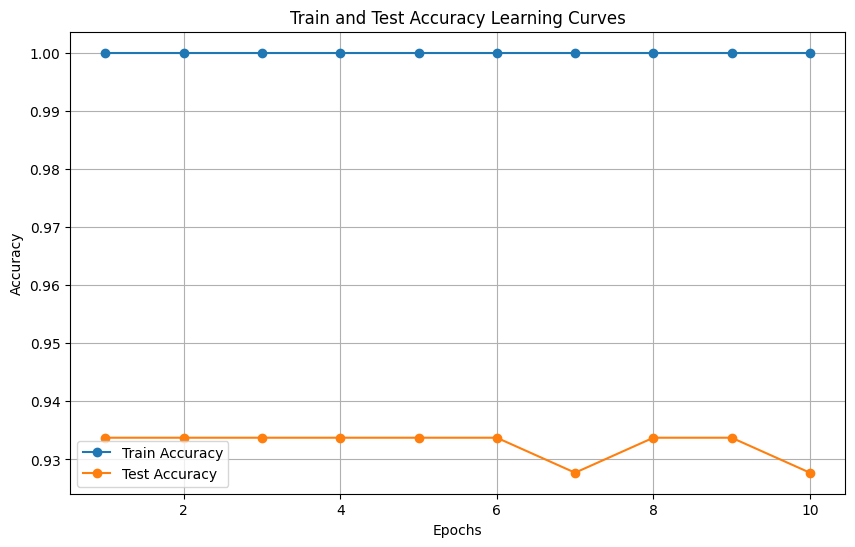

In [ ]:
# Plot accuracy learning curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load and preprocess the image
image_path = '/content/sample_data/Agricultural-crops/tea/images7.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
inputs = processor(images=image, return_tensors="pt").to(device)

# Perform inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs).logits

# Get predicted class
predicted_class_idx = torch.argmax(outputs, dim=1).item()
predicted_class_name = dataset.classes[predicted_class_idx]

print(f'Predicted class: {predicted_class_name}')


Predicted class: tea


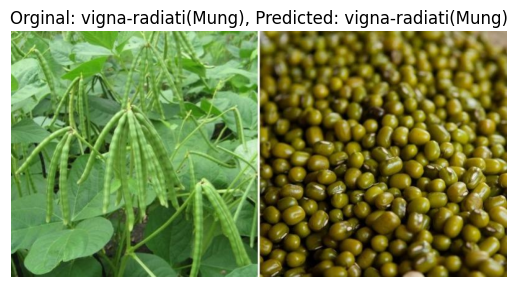

Predicted class: vigna-radiati(Mung)


In [ ]:
# prompt: test the above model using the image and also print image and original and pridicted class name on it

# Load and preprocess the image
image_path = '/content/sample_data/Agricultural-crops/vigna-radiati(Mung)/image (4).jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
inputs = processor(images=image, return_tensors="pt").to(device)

# Perform inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs).logits

# Get predicted class
predicted_class_idx = torch.argmax(outputs, dim=1).item()
predicted_class_name = dataset.classes[predicted_class_idx]

# Get the true class name from the file path
true_class_name = image_path.split('/')[-2]  # Assuming the directory name is the class

# Display the image with true and predicted labels
plt.imshow(image)
plt.title(f'Orginal: {true_class_name}, Predicted: {predicted_class_name}')
plt.axis('off')
plt.show()

Displaying Classification Report:
                     precision    recall  f1-score   support

             Cherry       1.00      1.00      1.00         8
       Coffee-plant       0.88      0.88      0.88         8
           Cucumber       0.80      0.80      0.80         5
   Fox_nut(Makhana)       0.80      1.00      0.89         4
              Lemon       1.00      1.00      1.00         5
         Olive-tree       1.00      1.00      1.00         7
Pearl_millet(bajra)       1.00      1.00      1.00        10
      Tobacco-plant       0.90      1.00      0.95         9
             almond       1.00      0.67      0.80         3
             banana       1.00      1.00      1.00         3
           cardamom       0.60      0.75      0.67         4
             chilli       1.00      1.00      1.00         4
              clove       0.86      1.00      0.92         6
            coconut       1.00      1.00      1.00         2
             cotton       0.82      1.00      0.90

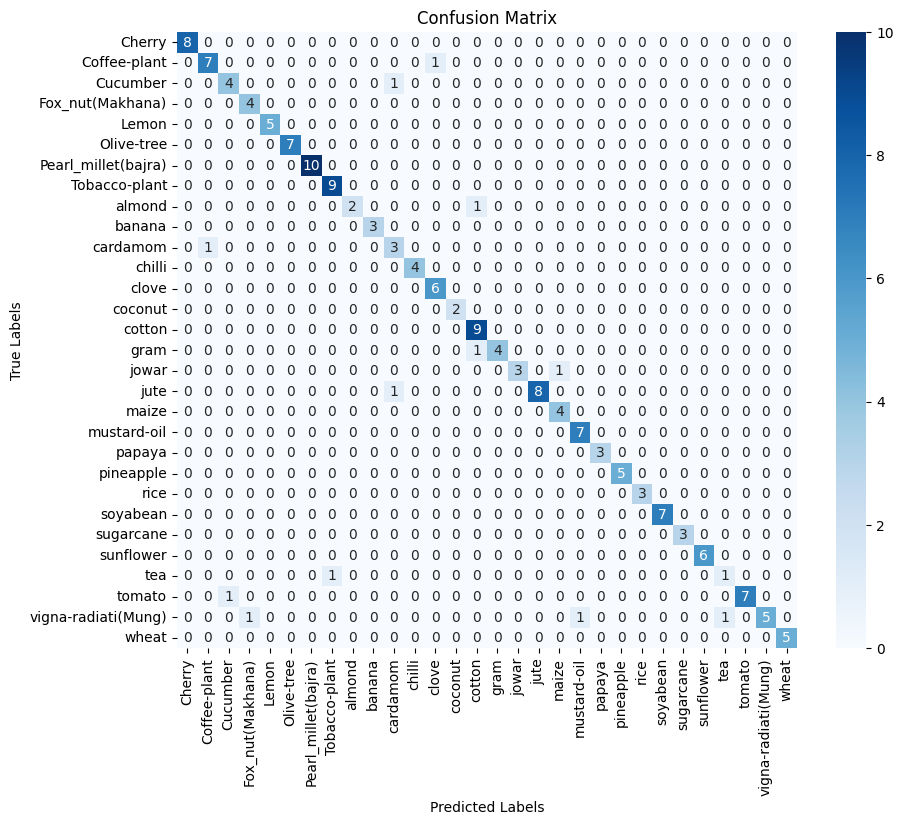

In [ ]:
# prompt: evaluate above model using evaluation methods of classification

from sklearn.metrics import classification_report, confusion_matrix

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate the model on the test dataset
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate classification report
print("Displaying Classification Report:")
report = classification_report(true_labels, predicted_labels, target_names=dataset.classes)
print(report)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Displaying Confusion Matrix:")
# Plot confusion matrix (optional)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
